In [1]:
%load_ext autoreload
%autoreload 2
    
import sys
sys.path.insert(0, '../../src')

import pymoca.parser
import pymoca.backends.sympy.generator as generator
import pylab as pl
import sympy
import sympy.physics.vector
sympy.init_printing()

%matplotlib inline

# Modelica Source Code

In [2]:
with open('../models/Spring.mo') as spring_test_model:
    modelica_src = spring_test_model.read()
print(modelica_src)

model Spring
    Real x, v_x;
    parameter Real c = 0.1;
    parameter Real k = 2;
equation
    der(x) = v_x;
    der(v_x) = -k*x - c*v_x;
end Spring;
// vim: set noet fenc= ft=modelica ff=unix sts=0 sw=4 ts=4 :



# Generation of Abstract Syntax Tree

In [3]:
ast = pymoca.parser.parse(modelica_src)
ast.classes['Spring'].symbols.keys()

odict_keys(['x', 'v_x', 'c', 'k'])

In [4]:
ast

Tree(classes=OrderedDict([('Spring', Class(type='model', name='Spring'))]))

# Generation of Sympy Model

In [5]:
# Set initial conditions for x and v_x to 1.0
symbols = ast.classes['Spring'].symbols
symbols['x'].start = pymoca.ast.Primary(value=1.0)
symbols['v_x'].start = pymoca.ast.Primary(value=1.0)
# Generate model
src_code = generator.generate(ast, 'Spring')
print(src_code)


# do not edit, generated by pymoca

from __future__ import print_function, division
import sympy
import sympy.physics.mechanics as mech
from pymoca.backends.sympy.runtime import OdeModel
from sympy import sin, cos, tan


class Spring(OdeModel):

    def __init__(self):

        super(Spring, self).__init__()

        # states
        x, v_x = mech.dynamicsymbols('x, v_x')
        self.x = sympy.Matrix([x, v_x])
        self.x0 = {
            x : 1.0,
            v_x : 1.0,
            }

        # variables
        self.v = sympy.Matrix([])

        # constants
        self.c = sympy.Matrix([])
        self.c0 = {
            }

        # parameters
        c, k = sympy.symbols('c, k')
        self.p = sympy.Matrix([c, k])
        self.p0 = {
            c : 0.1,
            k : 2,
            }

        # inputs
        self.u = sympy.Matrix([])
        self.u0 = {
            }

        # outputs
        self.y = sympy.Matrix([])

        # equations
        self.eqs = [
          

In [6]:
exec(src_code)
model = Spring()
model

{'t': t, 'x': Matrix([
[  x(t)],
[v_x(t)]]), 'u': Matrix(0, 0, []), 'y': Matrix(0, 0, []), 'p': Matrix([
[c],
[k]]), 'c': Matrix(0, 0, []), 'v': Matrix(0, 0, []), 'x0': {x(t): 1.0, v_x(t): 1.0}, 'u0': {}, 'p0': {c: 0.1, k: 2}, 'c0': {}, 'eqs': [-v_x(t) + Derivative(x(t), t), c*v_x(t) + k*x(t) + Derivative(v_x(t), t)], 'f': Matrix([
[            v_x(t)],
[-c*v_x(t) - k*x(t)]]), 'g': Matrix(0, 0, [])}

In [7]:
t = sympy.Symbol('t')
model.x.diff(t)

⎡d        ⎤
⎢──(x(t)) ⎥
⎢dt       ⎥
⎢         ⎥
⎢d        ⎥
⎢──(vₓ(t))⎥
⎣dt       ⎦

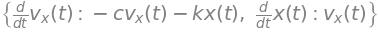

In [8]:
sol = sympy.solve(model.eqs, list(model.v) + list(model.x.diff(t)))
sol

In [9]:
model.x.diff(t).subs(sol)

⎡      vₓ(t)      ⎤
⎢                 ⎥
⎣-c⋅vₓ(t) - k⋅x(t)⎦

# Simulation of Sympy Model

In [10]:
model.f

⎡      vₓ(t)      ⎤
⎢                 ⎥
⎣-c⋅vₓ(t) - k⋅x(t)⎦

In [11]:
ss_sub = {}
ss_sub.update({model.x[i]: sympy.DeferredVector('x')[i] for i in range(len(model.x))})
ss_sub

In [12]:
res = model.simulate(t0=10, tf=20, dt=0.001)

Text(0, 0.5, 'x')

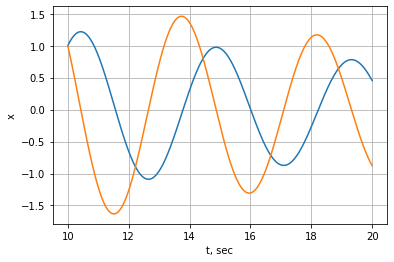

In [13]:
pl.plot(res['t'], res['x'])
pl.grid()
pl.xlabel('t, sec')
pl.ylabel('x')

# Jacobian

In [14]:
sympy.init_printing()
model.f

⎡      vₓ(t)      ⎤
⎢                 ⎥
⎣-c⋅vₓ(t) - k⋅x(t)⎦

In [15]:
model.f.jacobian(model.x)

⎡0   1 ⎤
⎢      ⎥
⎣-k  -c⎦

# Parameter Sensitivity

In [16]:
model.f.jacobian(model.p)

⎡  0       0  ⎤
⎢             ⎥
⎣-vₓ(t)  -x(t)⎦